In [ ]:
# default_exp modeling.question_answering

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.question_answering

> This module contains custom models, loss functions, custom splitters, etc... for question answering tasks

In [ ]:
#export
import ast

from blurr.data.all import *
from blurr.modeling.core import *

import torch
from transformers import *
from fastai2.text.all import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Question Answer

Given a document (context) and a question, the objective of these models is to predict the start and end token of the correct answer as it exists in the context.

In [ ]:
#export
class HF_QstAndAnsModelCallback(HF_BaseModelCallback):  
    
    def begin_batch(self):
        x = self.xb[0]
        model_args = [x[0]]
        if (self._include_arg('attention_mask', x[1])): model_args.append(x[1])
        if (self._include_arg('token_type_ids', x[2])): model_args.append(x[2])
        if (self._include_arg('cls_index', x[3])): model_args.append(x[3])
        if (self._include_arg('p_mask', x[4])): model_args.append(x[4])

        self.learn.xb = tuplify(model_args)
        
    def after_pred(self): self.learn.pred = self.pred

In [ ]:
#export
class HF_QstAndAnsModelWrapper(HF_BaseModelWrapper):
    """A custom model wrapper for question answer models since we need all the outputs (not just the first)"""
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('attention_mask', x[1])): model_kwargs['attention_mask'] = x[1]
        if (self._include_arg('token_type_ids', x[2])): model_kwargs['token_type_ids'] = x[2]
        if (self._include_arg('cls_index', x[3])): model_kwargs['cls_index'] = x[3]
        if (self._include_arg('p_mask', x[4])): model_kwargs['p_mask'] = x[4]
        
        outputs = self.hf_model(**model_kwargs)
        return outputs

And here we provide a custom loss function our question answer task, expanding on some techniques learned from here and here.

In fact, this new loss function can be used in many other multi-modal architectures, with any mix of loss functions.  For example, this can be ammended to include the `is_impossible` task, as well as the start/end token tasks in the SQUAD v2 dataset.

In [ ]:
#export
class MultiTargetLoss(Module):
    """Provides the ability to apply different loss functions to multi-modal targets/predictions"""
    def __init__(self, loss_classes=[CrossEntropyLossFlat, CrossEntropyLossFlat], loss_classes_kwargs=[{}, {}], 
                 weights=[1, 1], reduction='mean'):
        
        loss_funcs = [ cls(reduction=reduction, **kwargs) for cls, kwargs in zip(loss_classes, loss_classes_kwargs) ]
        store_attr(self, 'loss_funcs, weights')
        self._reduction = reduction
        
    # custom loss function must have either a reduction attribute or a reduction argument (like all fastai and
    # PyTorch loss functions) so that the framework can change this as needed (e.g., when doing lear.get_preds 
    # it will set = 'none'). see this forum topic for more info: https://bit.ly/3br2Syz
    @property
    def reduction(self): return self._reduction
    
    @reduction.setter
    def reduction(self, v): 
        self._reduction = v
        for lf in self.loss_funcs: lf.reduction = v

    def forward(self, outputs, *targets):
        loss = 0.
        for i, loss_func, weights, output, target in zip(range(len(outputs)), 
                                                         self.loss_funcs, self.weights,
                                                         outputs, targets):
            loss += weights * loss_func(output, target) 
                
        return loss
    
    def activation(self, outs): 
        acts = [ self.loss_funcs[i].activation(o) for i, o in enumerate(outs) ]
        return acts

    def decodes(self, outs):   
        decodes = [ self.loss_funcs[i].decodes(o) for i, o in enumerate(outs) ]
        return decodes


Again, we'll use a subset of pre-processed SQUAD v2 for our purposes below.

In [ ]:
path = Path('./')
squad_df = pd.read_csv(path/'squad_sample.csv'); len(squad_df)

1000

In [ ]:
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33
1,Cyprus,"Following the death in 1473 of James II, the last Lusignan king, the Republic of Venice assumed control of the island, while the late king's Venetian widow, Queen Catherine Cornaro, reigned as figurehead. Venice formally annexed the Kingdom of Cyprus in 1489, following the abdication of Catherine. The Venetians fortified Nicosia by building the Venetian Walls, and used it as an important commercial hub. Throughout Venetian rule, the Ottoman Empire frequently raided Cyprus. In 1539 the Ottomans destroyed Limassol and so fearing the worst, the Venetians also fortified Famagusta and Kyrenia.",572e7f8003f98919007566df,In what year did the Ottomans destroy Limassol?,False,1539,481,485


In [ ]:
pretrained_model_name = 'bert-large-uncased-whole-word-masking-finetuned-squad'
hf_tokenizer_cls = BertTokenizer
hf_model_cls = HF_MODELS.BertForQuestionAnswering

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name,
                                                                               hf_tokenizer_cls,
                                                                               hf_model_cls)


# # here's a pre-trained roberta model for squad you can try too
# pretrained_model_name = "ahotrod/roberta_large_squad2"
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

# # here's a pre-trained xlm model for squad you can try too
# pretrained_model_name = 'xlm-mlm-ende-1024'
# hf_arch, hf_tokenizer, hf_config, hf_model = \
#     BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, task=HF_TASKS_AUTO.ForQuestionAnswering)

In [ ]:
def pre_process_squad(row):
    context, qst, ans = row['context'], row['question_text'], row['answer_text']
    
    add_prefix_space = hf_arch in ['gpt2', 'roberta']
    
    if(hf_tokenizer.padding_side == 'right'):
        tok_input = hf_tokenizer.convert_ids_to_tokens(hf_tokenizer.encode(qst, context, 
                                                                           add_prefix_space=add_prefix_space))
    else:
        tok_input = hf_tokenizer.convert_ids_to_tokens(hf_tokenizer.encode(context, qst, 
                                                                           add_prefix_space=add_prefix_space))
                                                                       
    tok_ans = hf_tokenizer.tokenize(str(row['answer_text']), 
                                    add_special_tokens=False, 
                                    add_prefix_space=add_prefix_space)
    
    start_idx, end_idx = 0,0
    for idx, tok in enumerate(tok_input):
        try:
            if (tok == tok_ans[0] and tok_input[idx:idx + len(tok_ans)] == tok_ans): 
                start_idx, end_idx = idx, idx + len(tok_ans)
                break
        except: pass
            
    row['tokenized_input'] = tok_input
    row['tokenized_input_len'] = len(tok_input)
    row['tok_answer_start'] = start_idx
    row['tok_answer_end'] = end_idx
    
    return row

In [ ]:
squad_df = squad_df.apply(pre_process_squad, axis=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (16 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (12 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
#hide
squad_df.head(2)

,title,context,question_id,question_text,is_impossible,answer_text,answer_start,answer_end,tokenized_input,tokenized_input_len,tok_answer_start,tok_answer_end
0,New_York_City,"The New York City Fire Department (FDNY), provides fire protection, technical rescue, primary response to biological, chemical, and radioactive hazards, and emergency medical services for the five boroughs of New York City. The New York City Fire Department is the largest municipal fire department in the United States and the second largest in the world after the Tokyo Fire Department. The FDNY employs approximately 11,080 uniformed firefighters and over 3,300 uniformed EMTs and paramedics. The FDNY's motto is New York's Bravest.",56d1076317492d1400aab78c,What does FDNY stand for?,False,New York City Fire Department,4,33,"[[CLS], what, does, f, ##d, ##ny, stand, for, ?, [SEP], the, new, york, city, fire, department, (, f, ##d, ##ny, ), ,, provides, fire, protection, ,, technical, rescue, ,, primary, response, to, biological, ,, chemical, ,, and, radioactive, hazards, ,, and, emergency, medical, services, for, the, five, boroughs, of, new, york, city, ., the, new, york, city, fire, department, is, the, largest, municipal, fire, department, in, the, united, states, and, the, second, largest, in, the, world, after, the, tokyo, fire, department, ., the, f, ##d, ##ny, employs, approximately, 11, ,, 08, ##0, unif...",123,11,16
1,Cyprus,"Following the death in 1473 of James II, the last Lusignan king, the Republic of Venice assumed control of the island, while the late king's Venetian widow, Queen Catherine Cornaro, reigned as figurehead. Venice formally annexed the Kingdom of Cyprus in 1489, following the abdication of Catherine. The Venetians fortified Nicosia by building the Venetian Walls, and used it as an important commercial hub. Throughout Venetian rule, the Ottoman Empire frequently raided Cyprus. In 1539 the Ottomans destroyed Limassol and so fearing the worst, the Venetians also fortified Famagusta and Kyrenia.",572e7f8003f98919007566df,In what year did the Ottomans destroy Limassol?,False,1539,481,485,"[[CLS], in, what, year, did, the, ottomans, destroy, lima, ##sso, ##l, ?, [SEP], following, the, death, in, 147, ##3, of, james, ii, ,, the, last, lu, ##si, ##gnan, king, ,, the, republic, of, venice, assumed, control, of, the, island, ,, while, the, late, king, ', s, venetian, widow, ,, queen, catherine, corn, ##aro, ,, reigned, as, figure, ##head, ., venice, formally, annexed, the, kingdom, of, cyprus, in, 148, ##9, ,, following, the, abd, ##ication, of, catherine, ., the, venetian, ##s, fortified, nico, ##sia, by, building, the, venetian, walls, ,, and, used, it, as, an, important, comm...",139,110,112


In [ ]:
max_seq_len= 128

In [ ]:
squad_df = squad_df[(squad_df.tokenized_input_len < max_seq_len) & (squad_df.is_impossible == False)]

In [ ]:
vocab = list(range(max_seq_len))
# vocab = dict(enumerate(range(max_seq_len)));

In [ ]:
# account for tokenizers that pad on right or left side
trunc_strat = 'only_second' if (hf_tokenizer.padding_side == 'right') else 'only_first'
txt_cols = [['question_text'],['context']] if (hf_tokenizer.padding_side == 'right') else [['context'],['question_text']]

# override HF_BatchTransform defaults (optional)
hf_batch_tfm = HF_BatchTransform(hf_arch, hf_tokenizer, task=ForQuestionAnsweringTask(),
                                 max_seq_len=128, truncation_strategy=trunc_strat)

blocks = (
    HF_TextBlock.from_df(text_cols_lists=txt_cols, 
                         hf_arch=hf_arch, hf_tokenizer=hf_tokenizer, hf_batch_tfm=hf_batch_tfm),
    CategoryBlock(vocab=vocab),
    CategoryBlock(vocab=vocab)
)

# can't export lambda functions, so made the getter a standard method
def get_x(x): return (x.text0, x.text1)

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=[ColReader('tok_answer_start'), ColReader('tok_answer_end')],
                   splitter=RandomSplitter(),
                   n_inp=1)

In [ ]:
dls = dblock.dataloaders(squad_df, bs=4)

In [ ]:
len(dls.vocab), dls.vocab[1], dls.vocab[2]

(3, (#128) [0,1,2,3,4,5,6,7,8,9...], (#128) [0,1,2,3,4,5,6,7,8,9...])

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category,category_
0,"how do birds conserve energy? many, if not most, birds migrate in flocks. for larger birds, flying in flocks reduces the energy cost. geese in a v - formation may conserve 12 – 20 % of the energy they would need to fly alone. red knots calidris canutus and dunlins calidris alpina were found in radar studies to fly 5 km / h ( 3. 1 mph ) faster in flocks than when they were flying alone.",35,39
1,"dovrak has used what type of themes to impart a nationalist flavor? composers of classical music have often made use of folk music ( music created by musicians who are commonly not classically trained, often from a purely oral tradition ). some composers, like dvorak and smetana, have used folk themes to impart a nationalist flavor to their work, while others like bartok have used specific themes lifted whole from their folk - music origins.",27,28


In [ ]:
model = HF_QstAndAnsModelWrapper(hf_model)

In [ ]:
learn = Learner(dls, 
                hf_model,
                opt_func=partial(Adam, decouple_wd=True),
                cbs=[HF_QstAndAnsModelCallback],
                splitter=hf_splitter)

learn.loss_func=MultiTargetLoss()
learn.create_opt()                # -> will create your layer groups based on your "splitter" function
learn.freeze()

Notice above how I had to define the loss function *after* creating the `Learner` object.  I'm not sure why, but the `MultiTargetLoss` above prohibits the learner from being exported if I do.

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


In [ ]:
# x, y_start, y_end = dls.one_batch()
# preds = learn.model(x)
# len(preds),preds[0].shape

**Note:** The code above will only work if we are using the model wrapper (not the callback) as the callback does the work of ensuring our input into the huggingface model is correct ... and `learn.model(*x)` doesn't use it.

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=1.0964782238006592)

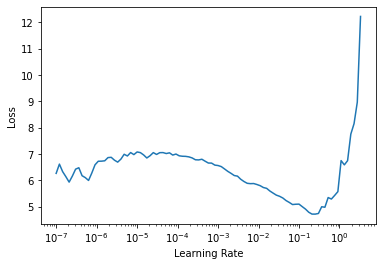

In [ ]:
#slow
learn.lr_find(suggestions=True)

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,4.412179,2.753212,00:17
1,2.954786,2.171412,00:17
2,2.420020,2.099426,00:15


In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, skip_special_tokens=True, max_n=2)

,text,category,category_,target1,target2
0,"the magnetic field is part of what sort of recorder? bell worked extensively in medical research and invented techniques for teaching speech to the deaf. during his volta laboratory period, bell and his associates considered impressing a magnetic field on a record as a means of reproducing sound. although the trio briefly experimented with the concept, they could not develop a workable prototype. they abandoned the idea, never realizing they had glimpsed a basic principle which would one day find its application in the tape recorder, the hard disc and floppy disc drive and other magnetic media.",99,101,99,101
1,"where was the university evacuated? between the german invasion of poland on 1 september 1939 and the anglo - french declaration of war against the german reich on 3 september 1939, the entire city ( a total of 120, 000 people ) was evacuated, like other border towns as well. until the arrival of the wehrmacht troops mid - june 1940, the city was, for ten months, completely empty, with the exception of the garrisoned soldiers. the jews of strasbourg had been evacuated to perigueux and limoges, the university had been evacuated to clermont - ferrand.",111,116,111,116


In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'text0': 'What did George Lucas make?',
    'text1': 'George Lucas created Star Wars in 1977. He directed and produced it.'   
}], 
    orient='columns')

learn.predict(inf_df.iloc[0])

(('11', '13'),
 tensor([11]),
 tensor([[1.9953e-05, 6.6960e-06, 7.5335e-07, 1.7125e-06, 7.1178e-07, 1.2500e-06,
          1.0880e-07, 1.9954e-05, 6.6870e-04, 4.3924e-05, 2.1026e-03, 9.9656e-01,
          7.1035e-05, 1.8911e-05, 3.0116e-05, 2.0009e-05, 2.4065e-04, 1.0099e-04,
          2.6297e-06, 3.6813e-05, 4.9420e-06, 1.9948e-05, 1.9984e-05, 8.5654e-08,
          9.5072e-08, 8.9944e-08, 8.9454e-08, 9.1328e-08, 9.4035e-08, 9.3781e-08,
          8.7999e-08, 9.0398e-08, 9.3350e-08, 9.2285e-08, 8.5133e-08, 8.3271e-08,
          8.7424e-08, 8.7053e-08, 8.3034e-08, 8.3653e-08, 8.4636e-08, 8.8034e-08,
          8.9929e-08, 8.7365e-08, 9.0708e-08, 9.0124e-08, 8.9394e-08, 8.8992e-08,
          8.9814e-08, 9.0405e-08, 9.4208e-08, 9.3037e-08, 9.1948e-08, 9.3707e-08,
          9.7754e-08, 9.7393e-08, 9.5191e-08, 9.2520e-08, 9.3175e-08, 9.8658e-08,
          9.7461e-08, 9.2410e-08, 9.0433e-08, 9.3034e-08, 9.8031e-08, 9.2164e-08,
          8.9365e-08, 9.1023e-08, 9.2003e-08, 9.6528e-08, 9.1928e-08

In [ ]:
inp_ids = hf_tokenizer.encode('What did George Lucas make?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[11:13]

['star', 'wars']

Note that there is a bug currently in fastai v2 (or with how I'm assembling everything) that currently prevents us from seeing the decoded predictions and probabilities for the "end" token.

In [ ]:
inf_df = pd.DataFrame.from_dict([{
    'text0': 'When was Star Wars made?',
    'text1': 'George Lucas created Star Wars in 1977. He directed and produced it.'
}], 
    orient='columns')

test_dl = dls.test_dl(inf_df)
inp, probs, _, preds = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)

In [ ]:
hf_tokenizer.convert_ids_to_tokens(inp[0].tolist()[0], 
                                   skip_special_tokens=False)[torch.argmax(probs[0]):torch.argmax(probs[1])]

['1977']

In [ ]:
learn.unfreeze()

In [ ]:
#slow
learn.fit_one_cycle(3, lr_max=slice(1e-7, 1e-4))

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 1; 10.91 GiB total capacity; 3.33 GiB already allocated; 9.88 MiB free; 3.34 GiB reserved in total by PyTorch)

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.show_results(hf_tokenizer=hf_tokenizer, max_n=2)

In [ ]:
learn.predict(inf_df.iloc[0])

In [ ]:
preds, pred_classes, probs = learn.predict(inf_df.iloc[0])
preds

In [ ]:
inp_ids = hf_tokenizer.encode('When was Star Wars made?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[int(preds[0]):int(preds[1])]

And what about inference?

Note that I had to replace the loss function because of the above-mentioned issue to exporting the model with the `MultiTargetLoss` loss function.  After getting our inference learner, we put it back and we're good to go!

In [ ]:
learn.loss_func = nn.CrossEntropyLoss()
learn.export(fname='q_and_a_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='q_and_a_learn_export.pkl')
inf_learn.loss_func = MultiTargetLoss()

inf_df = pd.DataFrame.from_dict([
    {'text0': 'Who created Star Wars?', 
     'text1': 'George Lucas created Star Wars in 1977. He directed and produced it.'}],
    orient='columns')

inf_learn.predict(inf_df.iloc[0])

In [ ]:
inp_ids = hf_tokenizer.encode('Who created Star Wars?',
                              'George Lucas created Star Wars in 1977. He directed and produced it.')

hf_tokenizer.convert_ids_to_tokens(inp_ids, skip_special_tokens=False)[7:9]

## Cleanup

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()